In [1]:
import os

import pandas as pd


from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima

import seaborn as sns
plt.style.use('seaborn-whitegrid')
import itertools
import warnings
warnings.filterwarnings('ignore')

/var/folders/ll/22q89fv95hbb3yt5tf_x_5lc0000gp/T/ipykernel_57827/2393257850.py:18: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


In [2]:
import yfinance as yf

start = "2014-09-17"
end = "2024-02-14"
symbol = {"BTC-USD"}
df = yf.download(symbol, start, end, auto_adjust=True)

df.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Volume
Date,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,21056800
2014-09-18,456.859985,456.859985,413.104004,424.440002,34483200
2014-09-19,424.102997,427.834991,384.532013,394.795990,37919700
2014-09-20,394.673004,423.295990,389.882996,408.903992,36863600
2014-09-21,408.084991,412.425995,393.181000,398.821014,26580100


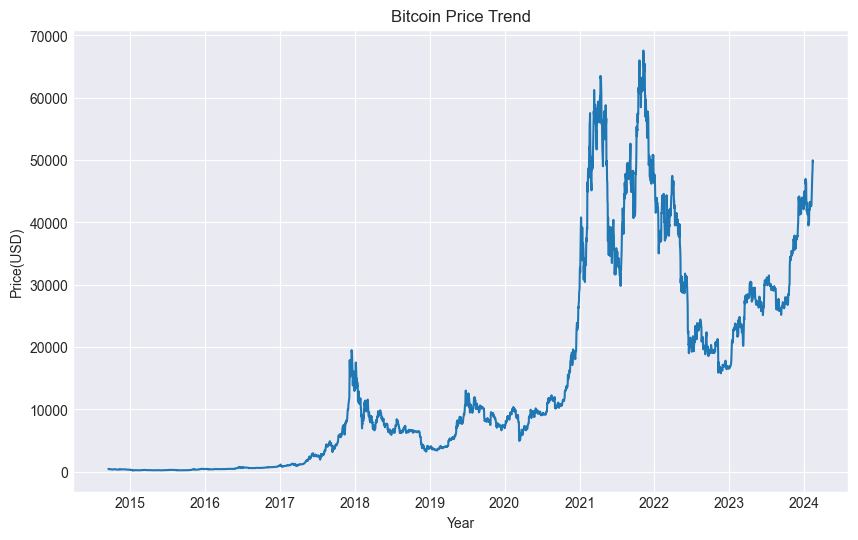

In [3]:
# Plot the time series data to understand its patterns and trends

plt.figure(figsize=(10,6))
sns.set_style('darkgrid')
plt.xlabel('Year')
plt.ylabel('Price(USD)')
plt.title("Bitcoin Price Trend")
plt.plot(df['Close'])

In [4]:
from statsmodels.tsa.stattools import adfuller
# If data is not stationary according to the ADF test, it has to be converted into a stationary data for building up Machine Learning Model.
# Define a function to perform the Augmented Dickey-Fuller (ADF) test

def augmented_dickey_fuller_test(timeseries):
    # Perform the ADF test
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # Print the results
    print('Results of Dickey-Fuller Test:')
    # Create a pandas Series to display the test statistics, p-value, number of lags used, and number of observations used
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])

    # Add critical values to the Series
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    
    # Print the Series containing test results
    print(dfoutput)
    
    # Determine stationarity
    if dftest[1] > 0.05:
        print("Is Stationary: No (fail to reject)")
    else:
        print("Is Stationary: Yes (reject)")

# Call the function to perform the ADF test
print(augmented_dickey_fuller_test(df['Close']))

Results of Dickey-Fuller Test:
Test Statistic                   -0.994984
p-value                           0.755089
#Lags Used                       29.000000
Number of Observations Used    3407.000000
Critical Value (1%)              -3.432271
Critical Value (5%)              -2.862389
Critical Value (10%)             -2.567222
dtype: float64
Is Stationary: No (fail to reject)
None


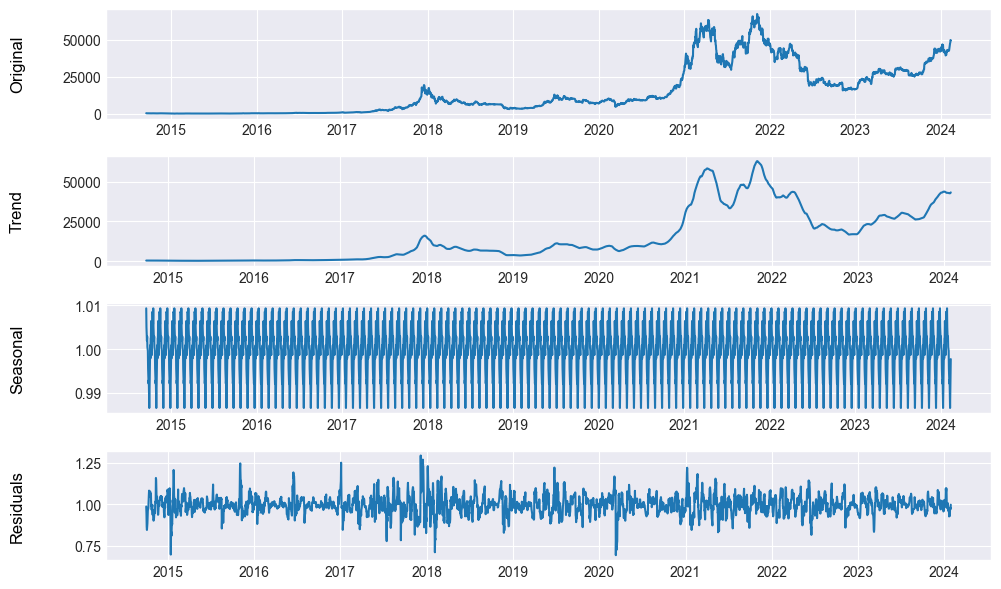

In [5]:
from statsmodels.tsa.seasonal import seasonal_decompose
# Perform Time Series Data Decomposition since it helps in understanding the underlying structure and preparing the data for further analysis or modeling.

decomposition = seasonal_decompose(df["Close"], model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(10, 6))
# Original
plt.subplot(411)
plt.plot(df["Close"], label='original')
plt.annotate('Original', xy=(0, 0.5), xytext=(-0.1, 0.5), rotation='vertical',
                 ha='center', va='center', fontsize=12, color='black', xycoords='axes fraction', textcoords='axes fraction')

# Trend
plt.subplot(412)
plt.plot(trend, label='trend')
plt.annotate('Trend', xy=(0, 0.5), xytext=(-0.1, 0.5), rotation='vertical',
                 ha='center', va='center', fontsize=12, color='black', xycoords='axes fraction', textcoords='axes fraction')

# Seasonality
plt.subplot(413)
plt.plot(seasonal, label='seasonality')
plt.annotate('Seasonal', xy=(0, 0.5), xytext=(-0.1, 0.5), rotation='vertical',
                 ha='center', va='center', fontsize=12, color='black', xycoords='axes fraction', textcoords='axes fraction')

# Residuals
plt.subplot(414)
plt.plot(residual, label='residuals')
plt.annotate('Residuals', xy=(0, 0.5), xytext=(-0.1, 0.5), rotation='vertical',
                 ha='center', va='center', fontsize=12, color='black', xycoords='axes fraction', textcoords='axes fraction')

plt.tight_layout()
plt.show()

In [6]:
# Check the trend's staionary after decomposition : NO

trend.dropna(inplace=True)
augmented_dickey_fuller_test(trend)

Results of Dickey-Fuller Test:
Test Statistic                   -0.793045
p-value                           0.821156
#Lags Used                       29.000000
Number of Observations Used    3377.000000
Critical Value (1%)              -3.432288
Critical Value (5%)              -2.862396
Critical Value (10%)             -2.567226
dtype: float64
Is Stationary: No (fail to reject)


In [7]:
# split 8 : 2
train_data, test_data = train_test_split(df, test_size=0.2, shuffle=False)

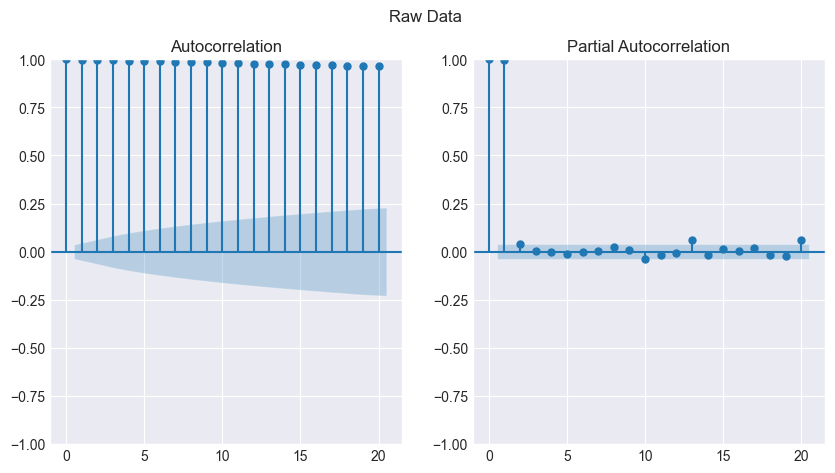

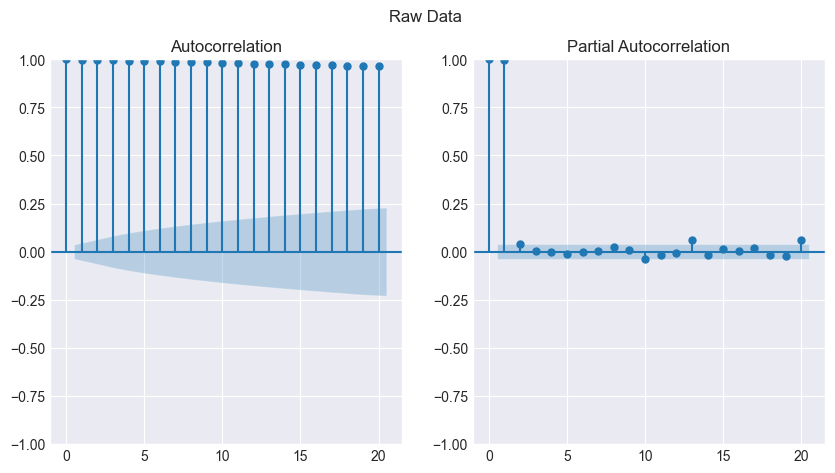

In [8]:
# ACF, PACF plot

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Raw Data')
sm.graphics.tsa.plot_acf(train_data['Close'].values.squeeze(), lags=20, ax=ax[0])
sm.graphics.tsa.plot_pacf(train_data['Close'].values.squeeze(), lags=20, ax=ax[1])

In [9]:
# Non-stationary -> stationary 보정 (차분, difference)
# differencing

diff_train_data = train_data.copy()
diff_train_data = diff_train_data['Close'].diff() # 차분
diff_train_data = diff_train_data.dropna() # 차분 후 생기는 결측치 제거
print()
print(train_data['Close'].head())
print()
print(diff_train_data.head())


Date
2014-09-17    457.334015
2014-09-18    424.440002
2014-09-19    394.795990
2014-09-20    408.903992
2014-09-21    398.821014
Name: Close, dtype: float64

Date
2014-09-18   -32.894012
2014-09-19   -29.644012
2014-09-20    14.108002
2014-09-21   -10.082977
2014-09-22     3.330994
Name: Close, dtype: float64


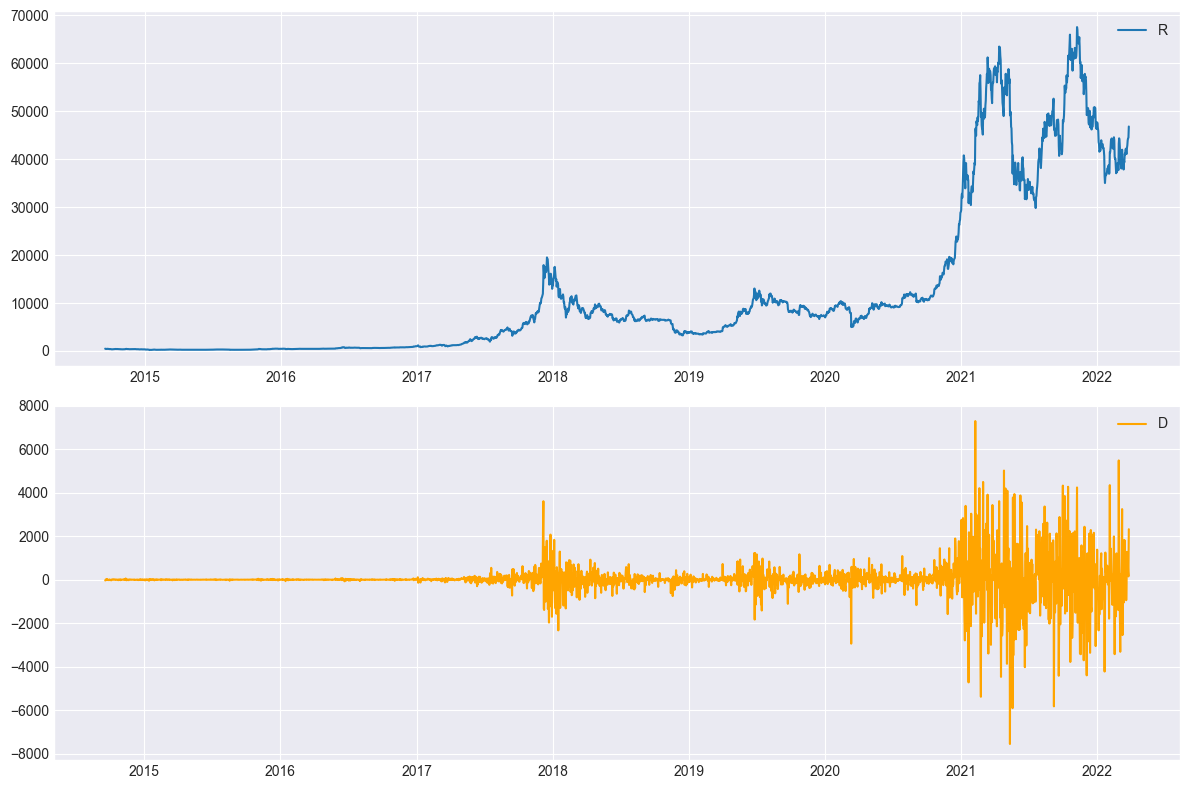

In [10]:
# 차분 시각화

fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)

ax1.plot(train_data['Close'])
ax1.legend('Raw data (Non-stationary)')

ax2.plot(diff_train_data, color='orange' )
ax2.legend('Differenced data (stationary)')


plt.tight_layout()
plt.show()

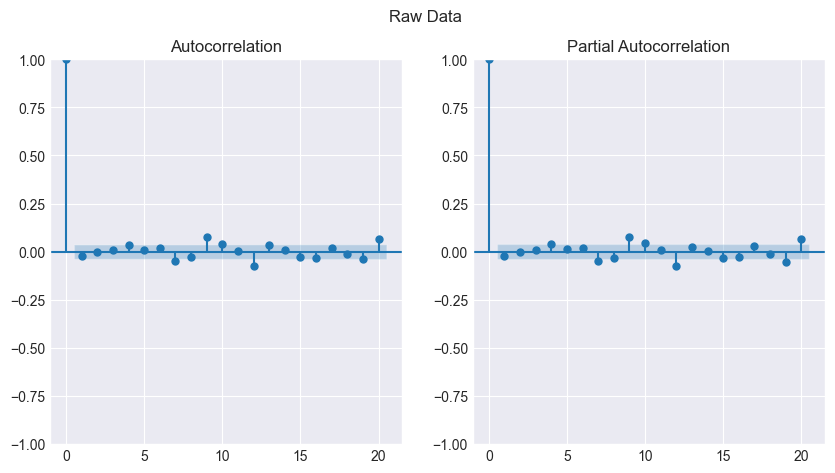

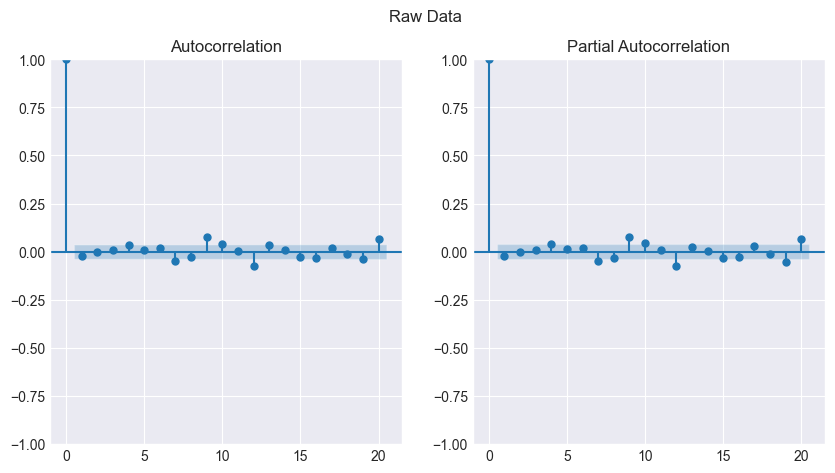

In [11]:
# ACF, PACF plot

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Raw Data')
sm.graphics.tsa.plot_acf(diff_train_data.values.squeeze(), lags=20, ax=ax[0])
sm.graphics.tsa.plot_pacf(diff_train_data.values.squeeze(), lags=20, ax=ax[1])

In [12]:
# parameter search

p = range(0, 3)
d = range(1, 2)
q = range(0, 3)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 3) for x in pdq]

AIC = []
params = []
for i in pdq :
    for j in seasonal_pdq :
        try : 
            model = SARIMAX(train_data['Close'].values, order=(i), seasonal_order = (j))
            model_fit = model.fit()
            print(f'SARIMA : {i},{j} >> AIC : {round(model_fit.aic, 2)}')
            AIC.append(round(model_fit.aic, 2))
            params.append((i, j))
            
        except Exception as e:
            print(e)
            continue

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.41982D+00    |proj g|=  1.31042D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      0      1      0     0     0   1.310D-06   8.420D+00
  F =   8.4198161220666208     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
SARIMA : (0, 1, 0),(0, 1, 0, 3) >> AIC : 46294.15
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  8.09811D+00    |proj g|=  1.50868D-03

At iterate   10    f=  8.09151D+00    |proj g|=  2.00925D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     11     12      1     0     0   7.342D-06   8.083D+00
  F =   8.0829267741970874     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
SARIMA : (0, 1, 0),(0, 1, 1, 3) >> AIC : 44443.93
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.12624D+00    |proj g|=  4.55882D-02


 This problem is unconstrained.



At iterate    5    f=  8.09495D+00    |proj g|=  5.52216D-03

At iterate   10    f=  8.09132D+00    |proj g|=  3.92071D-04

At iterate   15    f=  8.08350D+00    |proj g|=  8.94547D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     19     24      1     0     0   2.356D-06   8.083D+00
  F =   8.0828704764713386     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
SARIMA : (0, 1, 0),(0, 1, 2, 3) >> AIC : 44445.62
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    

 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      2      4      1     0     0   1.056D-06   8.273D+00
  F =   8.2725028835357293     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
SARIMA : (0, 1, 0),(1, 1, 0, 3) >> AIC : 45486.22
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.15508D+00    |proj g|=  9.06136D-02

At iterate    5    f=  8.10417D+00    |proj g|=  7.40090D-03

At iterate   10    f=  8.09591D+00    |proj g|=  1.22629D-03

At iterate   15    

 This problem is unconstrained.



At iterate    5    f=  8.08891D+00    |proj g|=  2.69087D-03

At iterate   10    f=  8.08775D+00    |proj g|=  1.85104D-04

At iterate   15    f=  8.08727D+00    |proj g|=  9.80267D-04

At iterate   20    f=  8.08345D+00    |proj g|=  9.39925D-04

At iterate   25    f=  8.08287D+00    |proj g|=  1.02977D-03

At iterate   30    f=  8.08253D+00    |proj g|=  8.45782D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     33     53      1     0     0   8.808D-06   8.083D+00
  F =   8.0825020319452054     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
SARIMA : (0, 1, 0),(1, 1, 2, 3) >> AIC : 44445.6
RU

 This problem is unconstrained.


SARIMA : (0, 1, 0),(2, 1, 0, 3) >> AIC : 45073.11
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.17341D+00    |proj g|=  8.11487D-02


 This problem is unconstrained.



At iterate    5    f=  8.12209D+00    |proj g|=  4.88210D-02

At iterate   10    f=  8.09552D+00    |proj g|=  1.82667D-03

At iterate   15    f=  8.09340D+00    |proj g|=  1.11991D-03

At iterate   20    f=  8.09332D+00    |proj g|=  6.64095D-04

At iterate   25    f=  8.08315D+00    |proj g|=  6.65014D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     29     39      1     0     0   4.728D-06   8.083D+00
  F =   8.0826428402471180     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
SARIMA : (0, 1, 0),(2, 1, 1, 3) >> AIC : 44446.37
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision 

 This problem is unconstrained.



At iterate    5    f=  8.08897D+00    |proj g|=  4.70177D-03

At iterate   10    f=  8.08705D+00    |proj g|=  2.99890D-04

At iterate   15    f=  8.08673D+00    |proj g|=  2.85296D-03

At iterate   20    f=  8.08659D+00    |proj g|=  7.35205D-04

At iterate   25    f=  8.08473D+00    |proj g|=  3.10093D-02

At iterate   30    f=  8.08226D+00    |proj g|=  4.68807D-03

At iterate   35    f=  8.08222D+00    |proj g|=  1.83185D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     38     47      1     0     0   1.805D-06   8.082D+00
  F =   8.0822194808603101     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL  

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  8.17709D+00    |proj g|=  1.29127D-03

At iterate   10    f=  8.10873D+00    |proj g|=  1.12836D-02

At iterate   15    f=  8.08265D+00    |proj g|=  3.76392D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     15     20      1     0     0   3.764D-06   8.083D+00
  F =   8.0826526499180336     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
SARIMA : (0, 1, 1),(0, 1, 1, 3) >> AIC : 44444.42
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    

 This problem is unconstrained.



At iterate    5    f=  8.17789D+00    |proj g|=  8.51870D-03

At iterate   10    f=  8.17544D+00    |proj g|=  4.68972D-04

At iterate   15    f=  8.10925D+00    |proj g|=  1.28407D-01

At iterate   20    f=  8.08259D+00    |proj g|=  2.44756D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     27      1     0     0   1.069D-06   8.083D+00
  F =   8.0825910758825898     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
SARIMA : (0, 1, 1),(0, 1, 2, 3) >> AIC : 44446.09
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0     

 This problem is unconstrained.



At iterate    5    f=  8.29213D+00    |proj g|=  1.50259D-03

At iterate   10    f=  8.29119D+00    |proj g|=  2.17655D-02

At iterate   15    f=  8.27518D+00    |proj g|=  2.89657D-02

At iterate   20    f=  8.27238D+00    |proj g|=  3.73035D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     20     23      1     0     0   3.730D-07   8.272D+00
  F =   8.2723762752436460     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
SARIMA : (0, 1, 1),(1, 1, 0, 3) >> AIC : 45487.52
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0     

 This problem is unconstrained.



At iterate    5    f=  8.18210D+00    |proj g|=  1.32097D-02

At iterate   10    f=  8.17560D+00    |proj g|=  1.33657D-03

At iterate   15    f=  8.17427D+00    |proj g|=  3.60535D-03

At iterate   20    f=  8.10248D+00    |proj g|=  1.47443D-01

At iterate   25    f=  8.08259D+00    |proj g|=  4.47589D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     31      1     0     0   4.476D-06   8.083D+00
  F =   8.0825886705639736     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
SARIMA : (0, 1, 1),(1, 1, 1, 3) >> AIC : 44446.07
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision 

 This problem is unconstrained.



At iterate    5    f=  8.17556D+00    |proj g|=  1.94279D-03

At iterate   10    f=  8.17477D+00    |proj g|=  4.44154D-04

At iterate   15    f=  8.13281D+00    |proj g|=  1.36920D-01

At iterate   20    f=  8.08265D+00    |proj g|=  1.67930D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     21     25      1     0     0   4.589D-06   8.083D+00
  F =   8.0826485984784391     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
SARIMA : (0, 1, 1),(1, 1, 2, 3) >> AIC : 44448.4
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0      

 This problem is unconstrained.



At iterate    5    f=  8.23990D+00    |proj g|=  1.38320D-03

At iterate   10    f=  8.23924D+00    |proj g|=  2.30394D-02

At iterate   15    f=  8.20348D+00    |proj g|=  1.00897D-01

At iterate   20    f=  8.19672D+00    |proj g|=  7.79059D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     24      1     0     0   4.816D-06   8.197D+00
  F =   8.1967162816929235     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
SARIMA : (0, 1, 1),(2, 1, 0, 3) >> AIC : 45073.55
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0     

 This problem is unconstrained.



At iterate    5    f=  8.19204D+00    |proj g|=  3.40714D-02

At iterate   10    f=  8.17715D+00    |proj g|=  4.21139D-03

At iterate   15    f=  8.17540D+00    |proj g|=  8.36447D-04

At iterate   20    f=  8.17499D+00    |proj g|=  4.57603D-03

At iterate   25    f=  8.08347D+00    |proj g|=  3.94356D-02

At iterate   30    f=  8.08238D+00    |proj g|=  4.16648D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     31     39      1     0     0   5.368D-06   8.082D+00
  F =   8.0823825938669902     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
SARIMA : (0, 1, 1),(2, 1, 1, 3) >> AIC : 44446.94
R

 This problem is unconstrained.



At iterate    5    f=  8.17663D+00    |proj g|=  1.01757D-02

At iterate   10    f=  8.17490D+00    |proj g|=  1.14926D-03

At iterate   15    f=  8.17476D+00    |proj g|=  9.07838D-03

At iterate   20    f=  8.08359D+00    |proj g|=  4.22046D-02

At iterate   25    f=  8.08254D+00    |proj g|=  1.05358D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     26     33      1     0     0   6.350D-06   8.083D+00
  F =   8.0825381570839721     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
SARIMA : (0, 1, 1),(2, 1, 2, 3) >> AIC : 44449.79
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision 

 This problem is unconstrained.



At iterate   10    f=  8.41242D+00    |proj g|=  1.56087D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     10     12      1     0     0   1.561D-05   8.412D+00
  F =   8.4124200580748703     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
SARIMA : (0, 1, 2),(0, 1, 0, 3) >> AIC : 46257.49
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.20680D+00    |proj g|=  4.51086D-02


 This problem is unconstrained.



At iterate    5    f=  8.17907D+00    |proj g|=  1.12707D-02

At iterate   10    f=  8.17625D+00    |proj g|=  4.42971D-04

At iterate   15    f=  8.10234D+00    |proj g|=  1.83148D-01

At iterate   20    f=  8.08265D+00    |proj g|=  7.91401D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     29      1     0     0   1.192D-05   8.083D+00
  F =   8.0826480821757674     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
SARIMA : (0, 1, 2),(0, 1, 1, 3) >> AIC : 44446.4
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0      

 This problem is unconstrained.



At iterate    5    f=  8.17945D+00    |proj g|=  7.99979D-03

At iterate   10    f=  8.17624D+00    |proj g|=  1.55964D-03

At iterate   15    f=  8.17608D+00    |proj g|=  1.15132D-03

At iterate   20    f=  8.15633D+00    |proj g|=  8.10892D-02

At iterate   25    f=  8.08263D+00    |proj g|=  4.19705D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     29     36      1     0     0   1.461D-06   8.083D+00
  F =   8.0825853199097981     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
SARIMA : (0, 1, 2),(0, 1, 2, 3) >> AIC : 44448.05
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision 

 This problem is unconstrained.



At iterate    5    f=  8.29244D+00    |proj g|=  2.31309D-04

At iterate   10    f=  8.29238D+00    |proj g|=  4.68852D-03

At iterate   15    f=  8.28702D+00    |proj g|=  4.70914D-02

At iterate   20    f=  8.27231D+00    |proj g|=  1.37905D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     25      1     0     0   6.347D-06   8.272D+00
  F =   8.2723096254748469     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
SARIMA : (0, 1, 2),(1, 1, 0, 3) >> AIC : 45489.16
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0     

 This problem is unconstrained.



At iterate    5    f=  8.18303D+00    |proj g|=  1.15583D-02

At iterate   10    f=  8.17645D+00    |proj g|=  1.27188D-03

At iterate   15    f=  8.17601D+00    |proj g|=  2.45896D-03

At iterate   20    f=  8.09372D+00    |proj g|=  1.42345D-01

At iterate   25    f=  8.08258D+00    |proj g|=  1.62899D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     27     33      1     0     0   1.057D-07   8.083D+00
  F =   8.0825828600527014     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
SARIMA : (0, 1, 2),(1, 1, 1, 3) >> AIC : 44448.04
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision 

 This problem is unconstrained.



At iterate    5    f=  8.17655D+00    |proj g|=  1.40779D-02

At iterate   10    f=  8.17554D+00    |proj g|=  7.47934D-04

At iterate   15    f=  8.12413D+00    |proj g|=  2.24776D-01

At iterate   20    f=  8.08264D+00    |proj g|=  2.06446D-05



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     21     48      2     0     0   5.880D-07   8.083D+00
  F =   8.0826401058965303     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
SARIMA : (0, 1, 2),(1, 1, 2, 3) >> AIC : 44450.36
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.24040D+00    |proj g|=  4.46783D-03


 This problem is unconstrained.



At iterate    5    f=  8.24037D+00    |proj g|=  2.27241D-03

At iterate   10    f=  8.23835D+00    |proj g|=  3.46973D-02

At iterate   15    f=  8.19993D+00    |proj g|=  5.26906D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     19     24      1     0     0   2.160D-05   8.197D+00
  F =   8.1966965504874203     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
SARIMA : (0, 1, 2),(2, 1, 0, 3) >> AIC : 45075.44
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    

 This problem is unconstrained.



At iterate    5    f=  8.19285D+00    |proj g|=  3.24047D-02

At iterate   10    f=  8.17716D+00    |proj g|=  2.89394D-03

At iterate   15    f=  8.17605D+00    |proj g|=  1.09973D-03

At iterate   20    f=  8.17601D+00    |proj g|=  9.43161D-04

At iterate   25    f=  8.17470D+00    |proj g|=  3.37759D-02

At iterate   30    f=  8.08243D+00    |proj g|=  7.23674D-03

At iterate   35    f=  8.08238D+00    |proj g|=  2.16129D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     35     43      1     0     0   2.161D-06   8.082D+00
  F =   8.0823759767085459     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL  

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.20288D+00    |proj g|=  4.26154D-02

At iterate    5    f=  8.17747D+00    |proj g|=  9.96727D-03

At iterate   10    f=  8.17559D+00    |proj g|=  1.28635D-03

At iterate   15    f=  8.17542D+00    |proj g|=  2.72930D-03

At iterate   20    f=  8.09342D+00    |proj g|=  1.22083D-01

At iterate   25    f=  8.08236D+00    |proj g|=  1.03065D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     27     36      1     0     0   

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  8.17807D+00    |proj g|=  9.68239D-03

At iterate   10    f=  8.17486D+00    |proj g|=  1.35791D-03

At iterate   15    f=  8.08265D+00    |proj g|=  2.54766D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     16     23      1     0     0   2.456D-06   8.083D+00
  F =   8.0826546697945130     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
SARIMA : (1, 1, 0),(0, 1, 1, 3) >> AIC : 44444.44


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.19600D+00    |proj g|=  2.78778D-02

At iterate    5    f=  8.17760D+00    |proj g|=  7.31541D-03

At iterate   10    f=  8.17514D+00    |proj g|=  4.74492D-04

At iterate   15    f=  8.08339D+00    |proj g|=  3.25151D-02

At iterate   20    f=  8.08259D+00    |proj g|=  1.02318D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     27      1     0     0   1.023D-07   8.083D+00
  F =   8.0825932233962039     

CONVERG

 This problem is unconstrained.



At iterate    5    f=  8.29200D+00    |proj g|=  1.73667D-03

At iterate   10    f=  8.29124D+00    |proj g|=  2.38350D-02

At iterate   15    f=  8.27625D+00    |proj g|=  4.66680D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     19     23      1     0     0   3.675D-06   8.272D+00
  F =   8.2723783601930219     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
SARIMA : (1, 1, 0),(1, 1, 0, 3) >> AIC : 45487.54
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    

 This problem is unconstrained.



At iterate    5    f=  8.18174D+00    |proj g|=  1.29827D-02

At iterate   10    f=  8.17534D+00    |proj g|=  1.24478D-03

At iterate   15    f=  8.16935D+00    |proj g|=  5.09315D-02

At iterate   20    f=  8.08267D+00    |proj g|=  1.30924D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     31      1     0     0   1.505D-07   8.083D+00
  F =   8.0825908231289780     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
SARIMA : (1, 1, 0),(1, 1, 1, 3) >> AIC : 44446.08
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0     

 This problem is unconstrained.



At iterate    5    f=  8.17531D+00    |proj g|=  2.14022D-03

At iterate   10    f=  8.17452D+00    |proj g|=  4.43898D-04

At iterate   15    f=  8.08616D+00    |proj g|=  8.32684D-02

At iterate   20    f=  8.08265D+00    |proj g|=  1.44180D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     20     28      1     0     0   1.442D-05   8.083D+00
  F =   8.0826489927710341     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
SARIMA : (1, 1, 0),(1, 1, 2, 3) >> AIC : 44448.4


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.23979D+00    |proj g|=  1.04608D-02

At iterate    5    f=  8.23969D+00    |proj g|=  1.91444D-03

At iterate   10    f=  8.23827D+00    |proj g|=  2.96363D-02

At iterate   15    f=  8.20490D+00    |proj g|=  1.11568D-01

At iterate   20    f=  8.19671D+00    |proj g|=  5.39718D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     26      1     0     0   4.673D-06   8.197D+00
  F =   8.1967119978376992     

CONVERG

 This problem is unconstrained.



At iterate    5    f=  8.19752D+00    |proj g|=  5.65242D-02

At iterate   10    f=  8.17730D+00    |proj g|=  1.04399D-02

At iterate   15    f=  8.17509D+00    |proj g|=  1.02931D-03

At iterate   20    f=  8.17471D+00    |proj g|=  2.40909D-03

At iterate   25    f=  8.08327D+00    |proj g|=  2.51436D-02

At iterate   30    f=  8.08238D+00    |proj g|=  6.70859D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     30     35      1     0     0   6.709D-06   8.082D+00
  F =   8.0823846955459775     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
SARIMA : (1, 1, 0),(2, 1, 1, 3) >> AIC : 44446.95


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.20200D+00    |proj g|=  4.30230D-02

At iterate    5    f=  8.17637D+00    |proj g|=  1.02358D-02

At iterate   10    f=  8.17463D+00    |proj g|=  1.21270D-03

At iterate   15    f=  8.17445D+00    |proj g|=  4.20454D-03

At iterate   20    f=  8.08271D+00    |proj g|=  1.74151D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     24     32      1     0     0   7.599D-05   8.083D+00
  F =   8.0825489637846193     

CONVERG

 This problem is unconstrained.



At iterate    5    f=  8.41699D+00    |proj g|=  8.46694D-02

At iterate   10    f=  8.40587D+00    |proj g|=  2.51792D-02

At iterate   15    f=  8.40285D+00    |proj g|=  3.03492D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     16     21      1     0     0   3.035D-05   8.403D+00
  F =   8.4028478760481988     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
SARIMA : (1, 1, 1),(0, 1, 0, 3) >> AIC : 46204.86
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    

 This problem is unconstrained.



At iterate    5    f=  8.17793D+00    |proj g|=  7.88952D-03

At iterate   10    f=  8.17545D+00    |proj g|=  1.19752D-03

At iterate   15    f=  8.08292D+00    |proj g|=  4.74909D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     15     20      1     0     0   4.749D-06   8.083D+00
  F =   8.0829225287568534     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
SARIMA : (1, 1, 1),(0, 1, 1, 3) >> AIC : 44447.91
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    

 This problem is unconstrained.



At iterate    5    f=  8.17837D+00    |proj g|=  1.17493D-02

At iterate   10    f=  8.17539D+00    |proj g|=  4.42445D-04

At iterate   15    f=  8.16275D+00    |proj g|=  1.61453D-01

At iterate   20    f=  8.08303D+00    |proj g|=  2.02625D-03

At iterate   25    f=  8.08296D+00    |proj g|=  4.78833D-04

At iterate   30    f=  8.08292D+00    |proj g|=  5.62251D-03

At iterate   35    f=  8.08287D+00    |proj g|=  1.58078D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     35     39      1     0     0   1.581D-06   8.083D+00
  F =   8.0828703488578508     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL  

 This problem is unconstrained.



At iterate    5    f=  8.29205D+00    |proj g|=  2.76918D-03

At iterate   10    f=  8.29125D+00    |proj g|=  1.38062D-03

At iterate   15    f=  8.29124D+00    |proj g|=  6.06577D-04

At iterate   20    f=  8.28463D+00    |proj g|=  8.25256D-02

At iterate   25    f=  8.27247D+00    |proj g|=  2.60212D-04

At iterate   30    f=  8.27240D+00    |proj g|=  6.61053D-03

At iterate   35    f=  8.27234D+00    |proj g|=  7.37181D-05

At iterate   40    f=  8.27232D+00    |proj g|=  3.81389D-03

At iterate   45    f=  8.27222D+00    |proj g|=  4.14207D-03

At iterate   50    f=  8.27209D+00    |proj g|=  1.50221D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  8.18280D+00    |proj g|=  1.71518D-02

At iterate   10    f=  8.17574D+00    |proj g|=  1.49693D-03

At iterate   15    f=  8.17529D+00    |proj g|=  1.45709D-03

At iterate   20    f=  8.08477D+00    |proj g|=  9.69758D-03

At iterate   25    f=  8.08330D+00    |proj g|=  5.06829D-03

At iterate   30    f=  8.08279D+00    |proj g|=  3.03566D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     32     42      1     0     0   1.704D-05   8.083D+00
  F =   8.0827880036248416     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
SARIMA : (1, 1, 1),(1, 1, 1, 3) >> AIC : 44449.17
R

 This problem is unconstrained.



At iterate    5    f=  8.17688D+00    |proj g|=  8.64876D-03

At iterate   10    f=  8.17487D+00    |proj g|=  4.44108D-04

At iterate   15    f=  8.17455D+00    |proj g|=  4.45047D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     17     37      1     0     0   5.334D-04   8.084D+00
  F =   8.0844838222381856     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
SARIMA : (1, 1, 1),(1, 1, 2, 3) >> AIC : 44460.49



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.23991D+00    |proj g|=  9.33505D-03

At iterate    5    f=  8.23983D+00    |proj g|=  2.35828D-03

At iterate   10    f=  8.23866D+00    |proj g|=  6.76403D-03

At iterate   15    f=  8.23652D+00    |proj g|=  2.34203D-02

At iterate   20    f=  8.19706D+00    |proj g|=  1.06581D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     24     30      1     0     0   6.639D-06   8.197D+00
  F =   8.1969971845060439     

CONVERG

 This problem is unconstrained.



At iterate    5    f=  8.19283D+00    |proj g|=  2.98290D-02

At iterate   10    f=  8.17677D+00    |proj g|=  2.16299D-03

At iterate   15    f=  8.17532D+00    |proj g|=  1.67980D-03

At iterate   20    f=  8.17527D+00    |proj g|=  4.43335D-04

At iterate   25    f=  8.08329D+00    |proj g|=  3.22888D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     29     43      1     0     0   3.422D-06   8.083D+00
  F =   8.0826435466288373     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
SARIMA : (1, 1, 1),(2, 1, 1, 3) >> AIC : 44450.37


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.20220D+00    |proj g|=  4.31712D-02

At iterate    5    f=  8.17596D+00    |proj g|=  2.99090D-03

At iterate   10    f=  8.17488D+00    |proj g|=  5.45244D-04

At iterate   15    f=  8.17467D+00    |proj g|=  4.70128D-03

At iterate   20    f=  8.08282D+00    |proj g|=  3.52685D-03

At iterate   25    f=  8.08237D+00    |proj g|=  1.52503D-03

At iterate   30    f=  8.08233D+00    |proj g|=  5.40998D-03

At iterate   35    f=  8.08226D+00    |proj g|=  4.24954D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.41887D+00    |proj g|=  1.93679D-02

At iterate    5    f=  8.34323D+00    |proj g|=  2.08997D-01

At iterate   10    f=  8.31918D+00    |proj g|=  1.30869D-01

At iterate   15    f=  8.30412D+00    |proj g|=  1.51932D-02

At iterate   20    f=  8.30048D+00    |proj g|=  9.24543D-02

At iterate   25    f=  8.30041D+00    |proj g|=  6.70867D-04

At iterate   30    f=  8.30010D+00    |proj g|=  9.13193D-01

At iterate   35    f=  8.28312D+00    |proj g|=  2.71276D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f=  8.17834D+00    |proj g|=  7.05241D-03

At iterate   10    f=  8.17564D+00    |proj g|=  3.23995D-03

At iterate   15    f=  8.17547D+00    |proj g|=  7.63220D-04

At iterate   20    f=  8.14173D+00    |proj g|=  1.92760D-01

At iterate   25    f=  8.08267D+00    |proj g|=  2.07816D-05

At iterate   30    f=  8.08266D+00    |proj g|=  1.61379D-04

At iterate   35    f=  8.08265D+00    |proj g|=  1.13230D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     36     44      1     0     0   1.852D-05   8.083D+00
  F =   8.0826488606452180     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f=  8.17834D+00    |proj g|=  1.77396D-02

At iterate   10    f=  8.17549D+00    |proj g|=  1.35174D-03

At iterate   15    f=  8.17531D+00    |proj g|=  2.44995D-03

At iterate   20    f=  8.10576D+00    |proj g|=  3.04226D-02

At iterate   25    f=  8.08497D+00    |proj g|=  2.01918D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     29     37      1     0     0   7.592D-06   8.083D+00
  F =   8.0825602774619565     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
SARIMA : (1, 1, 2),(0, 1, 2, 3) >> AIC : 44449.92
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision 

 This problem is unconstrained.



At iterate    5    f=  8.29210D+00    |proj g|=  2.16157D-03

At iterate   10    f=  8.29126D+00    |proj g|=  3.39743D-02

At iterate   15    f=  8.28914D+00    |proj g|=  1.45392D-03

At iterate   20    f=  8.28912D+00    |proj g|=  6.69159D-04

At iterate   25    f=  8.28751D+00    |proj g|=  2.22739D-02

At iterate   30    f=  8.27399D+00    |proj g|=  2.78126D-02

At iterate   35    f=  8.27176D+00    |proj g|=  1.22435D-03

At iterate   40    f=  8.27176D+00    |proj g|=  7.52076D-04

At iterate   45    f=  8.27175D+00    |proj g|=  1.08802D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     45     56   

 This problem is unconstrained.



At iterate    5    f=  8.18300D+00    |proj g|=  1.51214D-02

At iterate   10    f=  8.17616D+00    |proj g|=  2.31064D-03

At iterate   15    f=  8.17539D+00    |proj g|=  5.01436D-04

At iterate   20    f=  8.17477D+00    |proj g|=  3.11404D-02

At iterate   25    f=  8.08420D+00    |proj g|=  9.64045D-03

At iterate   30    f=  8.08262D+00    |proj g|=  1.04972D-03

At iterate   35    f=  8.08255D+00    |proj g|=  1.16513D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     35     45      1     0     0   1.165D-05   8.083D+00
  F =   8.0825548131987119     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.19734D+00    |proj g|=  4.69478D-02

At iterate    5    f=  8.17608D+00    |proj g|=  5.63711D-03

At iterate   10    f=  8.17489D+00    |proj g|=  4.44175D-04

At iterate   15    f=  8.17455D+00    |proj g|=  1.07714D-02
  ys=-1.122E-01  -gs= 7.426E-02 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     19     46      1     1     0   2.039D-01   8.104D+00
  F =   8.1037599215691696     

CONVERGENCE: REL_


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


SARIMA : (1, 1, 2),(1, 1, 2, 3) >> AIC : 44568.47
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.23986D+00    |proj g|=  2.89969D-03


 This problem is unconstrained.



At iterate    5    f=  8.23985D+00    |proj g|=  1.46583D-03

At iterate   10    f=  8.23943D+00    |proj g|=  1.64175D-02

At iterate   15    f=  8.23271D+00    |proj g|=  5.37649D-02

At iterate   20    f=  8.19806D+00    |proj g|=  3.78371D-02

At iterate   25    f=  8.19672D+00    |proj g|=  8.56062D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     25     30      1     0     0   8.561D-06   8.197D+00
  F =   8.1967155168859449     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
SARIMA : (1, 1, 2),(2, 1, 0, 3) >> AIC : 45077.54


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.22504D+00    |proj g|=  5.02647D-02

At iterate    5    f=  8.19658D+00    |proj g|=  5.19141D-02

At iterate   10    f=  8.17732D+00    |proj g|=  4.45526D-03

At iterate   15    f=  8.17534D+00    |proj g|=  8.63843D-04

At iterate   20    f=  8.17528D+00    |proj g|=  4.43339D-04

At iterate   25    f=  8.16023D+00    |proj g|=  5.72945D-02

At iterate   30    f=  8.12359D+00    |proj g|=  2.24251D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

 This problem is unconstrained.



At iterate    5    f=  8.17698D+00    |proj g|=  7.70776D-03

At iterate   10    f=  8.17494D+00    |proj g|=  1.83394D-03

At iterate   15    f=  8.17486D+00    |proj g|=  1.06159D-03

At iterate   20    f=  8.15309D+00    |proj g|=  1.22886D-01

At iterate   25    f=  8.09190D+00    |proj g|=  3.85869D-02

At iterate   30    f=  8.08254D+00    |proj g|=  4.79278D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     33     40      1     0     0   1.264D-05   8.083D+00
  F =   8.0825325587105219     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
SARIMA : (1, 1, 2),(2, 1, 2, 3) >> AIC : 44453.76
R

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  8.17849D+00    |proj g|=  7.49794D-03

At iterate   10    f=  8.17540D+00    |proj g|=  1.28788D-03

At iterate   15    f=  8.13903D+00    |proj g|=  1.14287D-01

At iterate   20    f=  8.08271D+00    |proj g|=  1.08626D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     29      1     0     0   5.186D-06   8.083D+00
  F =   8.0826457199380659     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
SARIMA : (2, 1, 0),(0, 1, 1, 3) >> AIC : 44446.39
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0     

 This problem is unconstrained.



At iterate    5    f=  8.17745D+00    |proj g|=  8.42135D-03

At iterate   10    f=  8.17535D+00    |proj g|=  7.54379D-04

At iterate   15    f=  8.17519D+00    |proj g|=  4.82700D-04

At iterate   20    f=  8.09571D+00    |proj g|=  1.26257D-01

At iterate   25    f=  8.08258D+00    |proj g|=  4.26803D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     26     36      1     0     0   8.166D-06   8.083D+00
  F =   8.0825847635198951     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
SARIMA : (2, 1, 0),(0, 1, 2, 3) >> AIC : 44448.05
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision 

 This problem is unconstrained.



At iterate    5    f=  8.29204D+00    |proj g|=  7.52468D-04

At iterate   10    f=  8.29184D+00    |proj g|=  1.13065D-02

At iterate   15    f=  8.27970D+00    |proj g|=  6.47108D-02

At iterate   20    f=  8.27236D+00    |proj g|=  1.23301D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     25      1     0     0   2.266D-06   8.272D+00
  F =   8.2723642794141643     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
SARIMA : (2, 1, 0),(1, 1, 0, 3) >> AIC : 45489.46
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0     

 This problem is unconstrained.



At iterate    5    f=  8.18187D+00    |proj g|=  1.14994D-02

At iterate   10    f=  8.17584D+00    |proj g|=  1.43431D-03

At iterate   15    f=  8.17506D+00    |proj g|=  6.97452D-04

At iterate   20    f=  8.09672D+00    |proj g|=  1.46664D-01

At iterate   25    f=  8.08258D+00    |proj g|=  4.29769D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     27     36      1     0     0   1.317D-06   8.083D+00
  F =   8.0825823779162960     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
SARIMA : (2, 1, 0),(1, 1, 1, 3) >> AIC : 44448.04
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision 

 This problem is unconstrained.



At iterate    5    f=  8.17629D+00    |proj g|=  2.88927D-02

At iterate   10    f=  8.17474D+00    |proj g|=  5.04440D-04

At iterate   15    f=  8.17379D+00    |proj g|=  1.82121D-02

At iterate   20    f=  8.09472D+00    |proj g|=  1.45743D-01

At iterate   25    f=  8.08264D+00    |proj g|=  1.89837D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     27     40      1     0     0   1.263D-05   8.083D+00
  F =   8.0826421540785152     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
SARIMA : (2, 1, 0),(1, 1, 2, 3) >> AIC : 44450.37
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision 

 This problem is unconstrained.



At iterate    5    f=  8.23974D+00    |proj g|=  9.01881D-04

At iterate   10    f=  8.23940D+00    |proj g|=  1.57230D-02

At iterate   15    f=  8.21154D+00    |proj g|=  1.16325D-01

At iterate   20    f=  8.19667D+00    |proj g|=  7.24368D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     21     23      1     0     0   4.438D-05   8.197D+00
  F =   8.1966748426770462     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
SARIMA : (2, 1, 0),(2, 1, 0, 3) >> AIC : 45075.32
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0     

 This problem is unconstrained.



At iterate    5    f=  8.19761D+00    |proj g|=  5.64626D-02

At iterate   10    f=  8.17816D+00    |proj g|=  5.98308D-03

At iterate   15    f=  8.17533D+00    |proj g|=  2.99093D-03

At iterate   20    f=  8.17514D+00    |proj g|=  4.43083D-04

At iterate   25    f=  8.17509D+00    |proj g|=  2.67434D-03

At iterate   30    f=  8.08626D+00    |proj g|=  8.35531D-02

At iterate   35    f=  8.08238D+00    |proj g|=  5.04300D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     37     47      1     0     0   4.969D-06   8.082D+00
  F =   8.0823757014670665     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL  

 This problem is unconstrained.



At iterate    5    f=  8.17662D+00    |proj g|=  7.35900D-03

At iterate   10    f=  8.17475D+00    |proj g|=  8.71890D-04

At iterate   15    f=  8.17462D+00    |proj g|=  1.49312D-03

At iterate   20    f=  8.10986D+00    |proj g|=  6.79477D-02

At iterate   25    f=  8.08570D+00    |proj g|=  1.50875D-02

At iterate   30    f=  8.08256D+00    |proj g|=  2.22460D-03

At iterate   35    f=  8.08243D+00    |proj g|=  4.34323D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     38     48      1     0     0   5.350D-05   8.082D+00
  F =   8.0824298211595540     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.44407D+00    |proj g|=  5.42180D-02

At iterate    5    f=  8.44160D+00    |proj g|=  1.22398D-01

At iterate   10    f=  8.37055D+00    |proj g|=  5.73631D-02

At iterate   15    f=  8.32315D+00    |proj g|=  1.37862D-02

At iterate   20    f=  8.31781D+00    |proj g|=  1.67394D-03

At iterate   25    f=  8.31689D+00    |proj g|=  1.80000D-03

At iterate   30    f=  8.31542D+00    |proj g|=  1.06070D-02

At iterate   35    f=  8.31523D+00    |proj g|=  6.45315D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

 This problem is unconstrained.



At iterate    5    f=  8.12339D+00    |proj g|=  2.75380D-02

At iterate   10    f=  8.11512D+00    |proj g|=  3.29890D-04

At iterate   15    f=  8.09670D+00    |proj g|=  2.24890D-02

At iterate   20    f=  8.08255D+00    |proj g|=  1.31885D-03

At iterate   25    f=  8.08225D+00    |proj g|=  9.52465D-05

At iterate   30    f=  8.08221D+00    |proj g|=  1.67610D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     32     44      1     0     0   3.328D-05   8.082D+00
  F =   8.0822049401342291     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
SARIMA : (2, 1, 1),(0, 1, 1, 3) >> AIC : 44445.96
R

 This problem is unconstrained.



At iterate    5    f=  8.12064D+00    |proj g|=  1.40605D-02

At iterate   10    f=  8.11531D+00    |proj g|=  5.63636D-04

At iterate   15    f=  8.11482D+00    |proj g|=  4.37865D-04

At iterate   20    f=  8.08262D+00    |proj g|=  1.19627D-02

At iterate   25    f=  8.08235D+00    |proj g|=  1.19393D-03

At iterate   30    f=  8.08235D+00    |proj g|=  5.36785D-04

At iterate   35    f=  8.08228D+00    |proj g|=  3.13162D-03

At iterate   40    f=  8.08220D+00    |proj g|=  5.74244D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     43     55      1     0     0   1.921D-05   8.082D+00
  F =   8.08220011886

 This problem is unconstrained.



At iterate    5    f=  8.27235D+00    |proj g|=  2.09660D-03

At iterate   10    f=  8.27058D+00    |proj g|=  7.12932D-02

At iterate   15    f=  8.24452D+00    |proj g|=  3.56873D-02

At iterate   20    f=  8.22411D+00    |proj g|=  1.13426D-02

At iterate   25    f=  8.22018D+00    |proj g|=  1.11945D-03

At iterate   30    f=  8.21978D+00    |proj g|=  3.60481D-03

At iterate   35    f=  8.21958D+00    |proj g|=  8.51433D-03

At iterate   40    f=  8.21675D+00    |proj g|=  1.55905D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     43     47      1     0     0   2.161D-06   8.217D+00
  F =   8.21674739931

 This problem is unconstrained.



At iterate    5    f=  8.12563D+00    |proj g|=  2.59776D-02

At iterate   10    f=  8.11569D+00    |proj g|=  3.72875D-03

At iterate   15    f=  8.11487D+00    |proj g|=  1.58846D-03

At iterate   20    f=  8.11485D+00    |proj g|=  2.28052D-03

At iterate   25    f=  8.11163D+00    |proj g|=  6.51731D-02

At iterate   30    f=  8.08244D+00    |proj g|=  2.75123D-03

At iterate   35    f=  8.08236D+00    |proj g|=  6.24260D-05

At iterate   40    f=  8.08234D+00    |proj g|=  4.75266D-03

At iterate   45    f=  8.08220D+00    |proj g|=  2.42488D-04

At iterate   50    f=  8.08220D+00    |proj g|=  7.90306D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  8.11822D+00    |proj g|=  2.75288D-02

At iterate   10    f=  8.11408D+00    |proj g|=  1.01618D-03

At iterate   15    f=  8.11402D+00    |proj g|=  3.58479D-03

At iterate   20    f=  8.10879D+00    |proj g|=  1.98592D-02

At iterate   25    f=  8.08581D+00    |proj g|=  1.36313D-02

At iterate   30    f=  8.08139D+00    |proj g|=  2.18607D-03

At iterate   35    f=  8.08136D+00    |proj g|=  1.18789D-04

At iterate   40    f=  8.08136D+00    |proj g|=  8.49893D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     43     57      1     0     0   4.096D-05   8.081D+00
  F =   8.08135925967

 This problem is unconstrained.



At iterate    5    f=  8.20208D+00    |proj g|=  3.20105D-04

At iterate   10    f=  8.20203D+00    |proj g|=  9.78317D-03

At iterate   15    f=  8.20132D+00    |proj g|=  3.86484D-03

At iterate   20    f=  8.20053D+00    |proj g|=  4.89350D-03

At iterate   25    f=  8.20032D+00    |proj g|=  2.96854D-04

At iterate   30    f=  8.20031D+00    |proj g|=  2.49509D-03

At iterate   35    f=  8.19771D+00    |proj g|=  1.18846D-02

At iterate   40    f=  8.19664D+00    |proj g|=  6.79085D-04

At iterate   45    f=  8.19658D+00    |proj g|=  7.77771D-03

At iterate   50    f=  8.19640D+00    |proj g|=  4.10990D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.18234D+00    |proj g|=  6.86068D-02

At iterate    5    f=  8.13769D+00    |proj g|=  6.95961D-02

At iterate   10    f=  8.11756D+00    |proj g|=  1.07808D-02

At iterate   15    f=  8.11482D+00    |proj g|=  3.24277D-03

At iterate   20    f=  8.11475D+00    |proj g|=  8.24621D-04

At iterate   25    f=  8.08620D+00    |proj g|=  4.98818D-02

At iterate   30    f=  8.08234D+00    |proj g|=  7.56827D-03

At iterate   35    f=  8.08223D+00    |proj g|=  6.90905D-05

At iterate   40    f=  8.08221D+00    |proj g|=  1.60672D-03

At iterate   45    f=  8.08212D+00    |proj g|=  8.97386D-04

At iterate   50    f=  8.08211D+00    |proj g|=  1.16833D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.15168D+00    |proj g|=  5.67694D-02

At iterate    5    f=  8.11722D+00    |proj g|=  1.23004D-02

At iterate   10    f=  8.11409D+00    |proj g|=  1.33732D-03

At iterate   15    f=  8.11406D+00    |proj g|=  5.25988D-04

At iterate   20    f=  8.11243D+00    |proj g|=  1.42172D-02

At iterate   25    f=  8.10864D+00    |proj g|=  4.57556D-02

At iterate   30    f=  8.08681D+00    |proj g|=  8.18453D-02

At iterate   35    f=  8.08303D+00    |proj g|=  8.89746D-03
  ys=-3.329E-04  -gs= 1.333E-04 BFGS update SKIPPED

At iterate   40    f=  8.08301D+00    |proj g|=  1.28498D-02



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     44    117      2     1     0   1.038D-02   8.083D+00
  F =   8.0830045715929888     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
SARIMA : (2, 1, 1),(2, 1, 2, 3) >> AIC : 44456.36
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.41925D+00    |proj g|=  3.05976D-02


 This problem is unconstrained.



At iterate    5    f=  8.41446D+00    |proj g|=  1.57807D-01

At iterate   10    f=  8.33140D+00    |proj g|=  5.79670D-02

At iterate   15    f=  8.28141D+00    |proj g|=  1.32973D-01

At iterate   20    f=  8.25971D+00    |proj g|=  1.20173D-01

At iterate   25    f=  8.25696D+00    |proj g|=  2.56951D-02

At iterate   30    f=  8.25684D+00    |proj g|=  1.70827D-02

At iterate   35    f=  8.25683D+00    |proj g|=  5.60412D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     35     44      1     0     0   5.604D-04   8.257D+00
  F =   8.2568284511782988     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.


           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.20609D+00    |proj g|=  4.51916D-02

At iterate    5    f=  8.17740D+00    |proj g|=  2.52782D-02

At iterate   10    f=  8.17543D+00    |proj g|=  4.42644D-04

At iterate   15    f=  8.16818D+00    |proj g|=  5.25798D-02

At iterate   20    f=  8.08214D+00    |proj g|=  5.45912D-04

At iterate   25    f=  8.08146D+00    |proj g|=  7.62347D-04

At iterate   30    f=  8.08099D+00    |proj g|=  4.81288D-05

At iterate   35    f=  8.08095D+00    |proj g|=  1.07215D-04

At iterate   40    f=  8.08090D+00    |proj g|=  1.67951D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final project

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.19621D+00    |proj g|=  2.78574D-02

At iterate    5    f=  8.17906D+00    |proj g|=  9.92375D-03

At iterate   10    f=  8.17552D+00    |proj g|=  1.78476D-03

At iterate   15    f=  8.17531D+00    |proj g|=  5.43605D-04

At iterate   20    f=  8.14033D+00    |proj g|=  6.17673D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     24     43      1     0     0   8.932D-03   8.136D+00
  F =   8.1362244104494099     

CONVERG

 This problem is unconstrained.



At iterate    5    f=  8.29209D+00    |proj g|=  4.79031D-03

At iterate   10    f=  8.29126D+00    |proj g|=  9.42164D-03

At iterate   15    f=  8.29062D+00    |proj g|=  4.93034D-02

At iterate   20    f=  8.27975D+00    |proj g|=  1.17416D-01

At iterate   25    f=  8.26892D+00    |proj g|=  1.07368D-01

At iterate   30    f=  8.23933D+00    |proj g|=  1.21023D-01

At iterate   35    f=  8.22254D+00    |proj g|=  8.89373D-02

At iterate   40    f=  8.21854D+00    |proj g|=  7.12875D-02

At iterate   45    f=  8.21824D+00    |proj g|=  6.49752D-03

At iterate   50    f=  8.21780D+00    |proj g|=  9.23556D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  8.18303D+00    |proj g|=  1.29646D-02

At iterate   10    f=  8.17581D+00    |proj g|=  2.42524D-03

At iterate   15    f=  8.17535D+00    |proj g|=  1.10435D-03

At iterate   20    f=  8.17531D+00    |proj g|=  1.42843D-03

At iterate   25    f=  8.11505D+00    |proj g|=  1.99276D-01

At iterate   30    f=  8.10530D+00    |proj g|=  5.19702D-02
  ys=-3.031E-03  -gs= 2.418E-03 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     33     83      2     1     0   3.635D-04   8.103D+00
  F =   8.1033989155674231     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
SARIMA : (2, 1, 2),(1, 1, 1, 3) >> AIC : 44566.49


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.19729D+00    |proj g|=  4.69064D-02

At iterate    5    f=  8.17680D+00    |proj g|=  7.48312D-03

At iterate   10    f=  8.17480D+00    |proj g|=  9.81204D-04

At iterate   15    f=  8.17457D+00    |proj g|=  2.84609D-03
LU decomposition error.
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.23982D+00    |proj g|=  1.47246D-03


 This problem is unconstrained.



At iterate    5    f=  8.23975D+00    |proj g|=  8.24866D-03

At iterate   10    f=  8.23610D+00    |proj g|=  1.31900D-02

At iterate   15    f=  8.22400D+00    |proj g|=  2.47159D-02

At iterate   20    f=  8.21851D+00    |proj g|=  3.25401D-03

At iterate   25    f=  8.16399D+00    |proj g|=  1.44587D-03

At iterate   30    f=  8.16398D+00    |proj g|=  3.85089D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     31     51      1     0     0   3.828D-04   8.164D+00
  F =   8.1639793014381841     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
SARIMA : (2, 1, 2),(2, 1, 0, 3) >> AIC : 44899.56


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.22499D+00    |proj g|=  5.05668D-02

At iterate    5    f=  8.19254D+00    |proj g|=  3.40370D-02

At iterate   10    f=  8.17698D+00    |proj g|=  2.87176D-03

At iterate   15    f=  8.17532D+00    |proj g|=  9.85531D-04

At iterate   20    f=  8.17526D+00    |proj g|=  4.43200D-04

At iterate   25    f=  8.16668D+00    |proj g|=  1.15018D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     28     50      1     0     0   


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


SARIMA : (2, 1, 2),(2, 1, 1, 3) >> AIC : 44558.06
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.20219D+00    |proj g|=  4.27860D-02


 This problem is unconstrained.



At iterate    5    f=  8.17656D+00    |proj g|=  1.34788D-02

At iterate   10    f=  8.17481D+00    |proj g|=  1.59572D-03

At iterate   15    f=  8.17478D+00    |proj g|=  2.16540D-03

At iterate   20    f=  8.17427D+00    |proj g|=  1.17187D-02

At iterate   25    f=  8.17157D+00    |proj g|=  4.81651D-02

At iterate   30    f=  8.13085D+00    |proj g|=  3.81460D-01



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     33    138      3     0     0   2.448D-01   8.131D+00
  F =   8.1307970248536581     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
SARIMA : (2, 1, 2),(2, 1, 2, 3) >> AIC : 44721.12


In [13]:
# optimal parameter
optim = [(params[i], j) for i, j in enumerate(AIC) if j == min(AIC)]
print(optim)

[(((2, 1, 2), (0, 1, 1, 3)), 44440.79)]


In [14]:
model = SARIMAX(train_data['Close'].values, order=optim[0][0][0], seasonal_order=optim[0][0][1])
model_fit = model.fit()

model_fit.summary()

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.20609D+00    |proj g|=  4.51916D-02

At iterate    5    f=  8.17740D+00    |proj g|=  2.52782D-02

At iterate   10    f=  8.17543D+00    |proj g|=  4.42644D-04

At iterate   15    f=  8.16818D+00    |proj g|=  5.25798D-02

At iterate   20    f=  8.08214D+00    |proj g|=  5.45912D-04

At iterate   25    f=  8.08146D+00    |proj g|=  7.62347D-04

At iterate   30    f=  8.08099D+00    |proj g|=  4.81288D-05

At iterate   35    f=  8.08095D+00    |proj g|=  1.07215D-04

At iterate   40    f=  8.08090D+00    |proj g|=  1.67951D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                 2749
Model:             SARIMAX(2, 1, 2)x(0, 1, [1], 3)   Log Likelihood              -22214.395
Date:                             Thu, 15 Feb 2024   AIC                          44440.790
Time:                                     14:08:35   BIC                          44476.295
Sample:                                          0   HQIC                         44453.619
                                            - 2749                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.9943      0.004   -491.871      0.000      -2.002      -1.986
ar.L2         -0.9976      0.004   -246.885      0.000      -1.006      -0.990
ma.L1          1.9950      0.005    363.461      0.000       1.984       2.006
ma.L2          0.9986      0.005    183.987      0.000       0.988       1.009
ma.S.L3       -1.0000      0.009   -111.464      0.000      -1.018      -0.982
sigma2      6.215e+05   1.44e-08    4.3e+13      0.000    6.21e+05    6.21e+05
===================================================================================
Ljung-Box (L1) (Q):                   1.03   Jarque-Bera (JB):             39587.40
Prob(Q):                              0.31   Prob(JB):                         0.00
Heteroskedasticity (H):            5026.16   Skew:                            -0.21
Prob(H) (two-sided):                  0.00   Kurtosis:                        21.60
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.53e+28. Standard errors may be unstable.
"""

In [15]:
pred = model_fit.get_forecast(len(test_data))
pred_val = pred.predicted_mean
pred_ub = pred.conf_int()[:, 0]
pred_lb = pred.conf_int()[:, 1]
pred_index = list(test_data.index)
r2 = r2_score(test_data['Close'].values, pred_val)

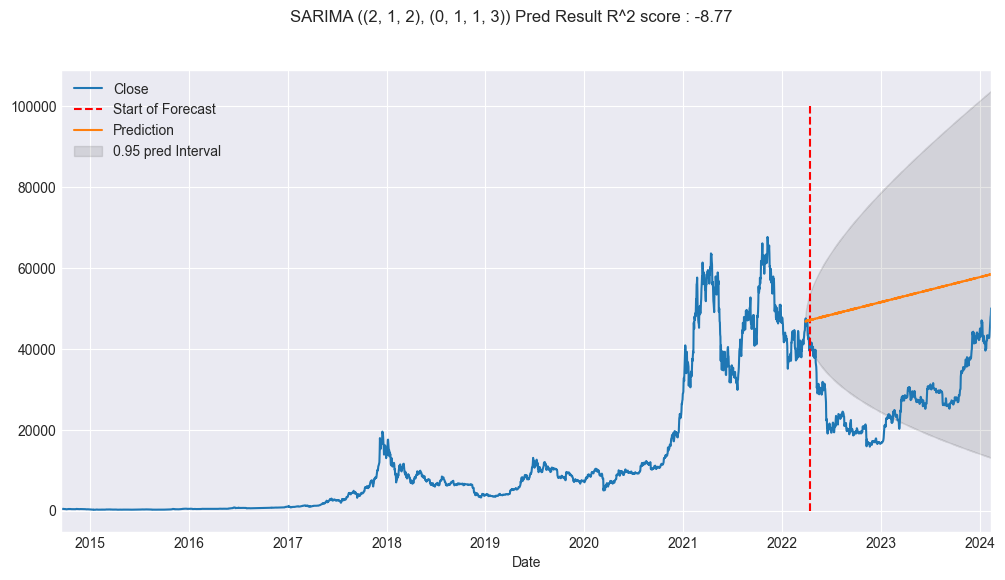

In [19]:
fig, ax = plt.subplots(figsize=(12, 6))
df['Close'].plot(ax =ax)
ax.vlines('2022-04-15', 0, 100000, linestyle='--',color='r', label='Start of Forecast')
ax.plot(pred_index, pred_val, label='Prediction')
ax.fill_between(pred_index, pred_lb, pred_ub, color='k', alpha=0.1, label='0.95 pred Interval')

ax.legend(loc='upper left')
plt.suptitle(f'SARIMA {optim[0][0]} Pred Result R^2 score : {round(r2, 2)}')
plt.show()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.20609D+00    |proj g|=  4.51916D-02


 This problem is unconstrained.



At iterate    5    f=  8.17740D+00    |proj g|=  2.52782D-02

At iterate   10    f=  8.17543D+00    |proj g|=  4.42644D-04

At iterate   15    f=  8.16818D+00    |proj g|=  5.25798D-02

At iterate   20    f=  8.08214D+00    |proj g|=  5.45912D-04

At iterate   25    f=  8.08146D+00    |proj g|=  7.62347D-04

At iterate   30    f=  8.08099D+00    |proj g|=  4.81288D-05

At iterate   35    f=  8.08095D+00    |proj g|=  1.07215D-04

At iterate   40    f=  8.08090D+00    |proj g|=  1.67951D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     41     53      1     0     0   4.492D-07   8.081D+00
  F =   8.08090036815

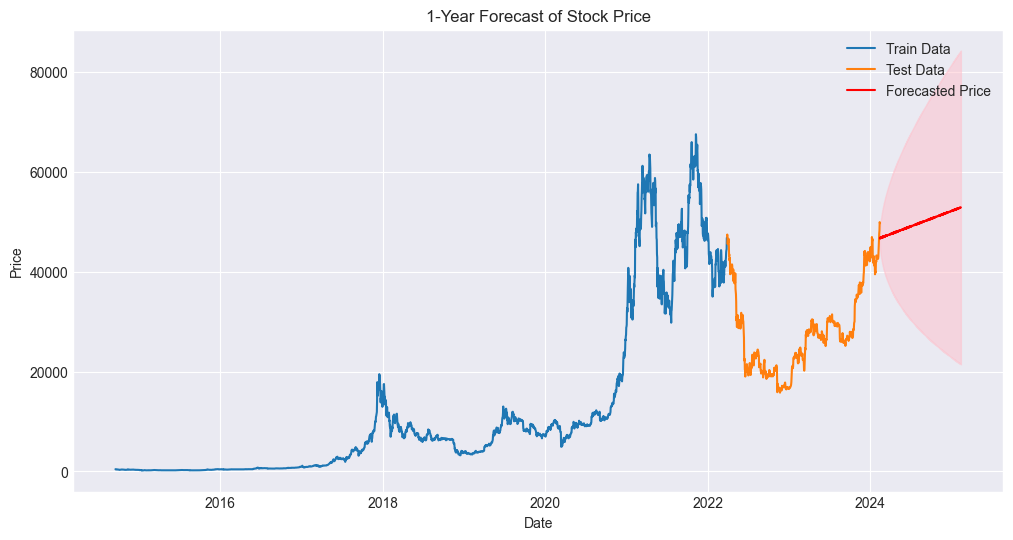

In [20]:
model = SARIMAX(train_data['Close'].values, order=optim[0][0][0], seasonal_order=optim[0][0][1])
model_fit = model.fit()
model_fit.summary()

# 1년 후의 가격 예측
forecast_period = 365  # 1년에 해당하는 일수
pred = model_fit.get_forecast(steps=forecast_period)
pred_val = pred.predicted_mean
pred_ub = pred.conf_int()[:, 0]
pred_lb = pred.conf_int()[:, 1]

# 예측 인덱스 생성
pred_index = pd.date_range(start=test_data.index[-1], periods=forecast_period, freq='D')

# 시각화
plt.figure(figsize=(12, 6))
plt.plot(train_data.index, train_data['Close'], label='Train Data')
plt.plot(test_data.index, test_data['Close'], label='Test Data')
plt.plot(pred_index, pred_val, color='red', label='Forecasted Price')
plt.fill_between(pred_index, pred_lb, pred_ub, color='pink', alpha=0.5)
plt.title('1-Year Forecast of Stock Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [21]:
# Current stock price
current_price = test_data.iloc[-1]['Close']

# Stock price one year later
future_price = pred_val[-1]

# Calculate the profit rate
profit_rate = ((future_price - current_price) / current_price) * 100

print(f"Current stock price: {current_price}")
print(f"Estimated stock price one year later: {future_price}")
print(f"One-year profit rate: {profit_rate:.2f}%")

Current stock price: 49742.44140625
Estimated stock price one year later: 52896.07553912974
One-year profit rate: 6.34%
